# 네이버 뉴스 기사 크롤링 BeautifulSoup와 newspaper3k를 통해 크롤러 만들기

In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [3]:
url_list[:5]

['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451723',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451721',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451718',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009849190',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451717']

코드로부터 바로 어떤 카테고리인지 확인하기 쉽도록 code를 키, 실제 카테고리를 밸류로 가지는 딕셔너리를 만들어두겠습니다

In [4]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

newspaper3k를 통해서 만들어진 함수로 URL 리스트와 해당 URL이 어떤 카테고리인지 코드를 알려주면 이를 통해 데이터프레임을 생성하는 함수입니다.

In [5]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [6]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


하나의 카테고리만이 아니라 다른 카테고리의 뉴스들에 대해서도 수집

사회, 생활/문화, IT/과학의 뉴스들을 수집

In [7]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

make_total_data() 라는 함수를 만듭니다. 이 함수는 내부적으로 앞서 만든 make_urllist 함수와 make_data 함수를 호출하도록 합니다.

In [8]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

마찬가지로 2020년 5월 6일 기사에 대해서 1페이지까지만 크롤링을 하되, 102번, 103번, 105번 코드를 가지는 카테고리의 뉴스들을 수집해서 데이터프레임에 저장해 보겠습니다.

In [9]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [10]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  60


In [11]:
df.head(10)

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회
5,질서정연 코로나19 확산 방지를 위한 ‘물리적 거리 두기’가 ‘생활 속 거리 두기’...,사회
6,“코로나19에 걸렸다 나은 친구는 아무래도 좀 멀리하게 될 것 같아요. 재발 가능성...,사회
7,1977년 메이저리그 LA 다저스의 시즌 마지막 경기였다. 신인 타자 더스티 베이커...,사회
8,"6일 등교수업을 앞둔 경북 한 학교의 보건실에는 손소독제, 마스크 등 방역물품이 상...",사회
9,경찰 로고./뉴스1 © News1 신채린 기자 경찰 로고./뉴스1 © News1 신...,사회


## 대량 크롤링

이번에는 좀 더 많은 데이터를 수집해 볼까요? 이번에 수집한 데이터로 머신 러닝 모델을 통해 카테고리를 예측하는 모델을 만들어보겠습니다. 이번에는 3개의 카테고리에 대해서 총 100개의 페이지에 대해서 크롤링하겠습니다. 시간이 4~50분 정도 소요됩니다.

In [12]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

In [13]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
#df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/aiffel0042/aiffel/news_crawler/news_data.csv File Saved!


### 저장해둔 csv파일을 데이터 프레임으로 저장

In [14]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',') # 데이터프레임으로 저장
df.tail()

,news,code
5119,신종 코로나바이러스 감염증(코로나19) 사태 이후 ‘가정의 달’ 5월에도 언택트(비...,IT/과학
5120,는 소비자로부터 월 이용료 1만~2만원을 받고 초고속 인터넷을 제공한다. 그런 SK...,IT/과학
5121,머리를 긁고 있는 오랑우탄. 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이...,IT/과학
5122,가 오는 15일 정식 출시하는 스마트폰 'LG벨벳'이 사실상 '공짜폰'이 될 전망이...,IT/과학
5123,이미지제공=게티이미지뱅크 이미지제공=게티이미지뱅크\n\n[Copyright ⓒ 전자...,IT/과학


In [15]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

In [16]:
print(df.isnull().sum()) #null 값 확인

news    0
code    0
dtype: int64


In [17]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


In [18]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


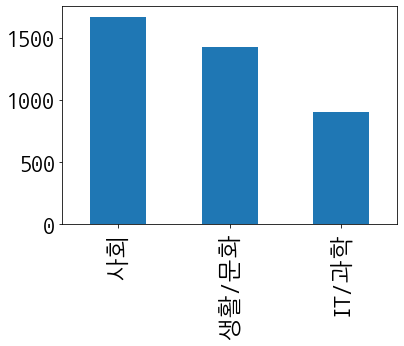

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 12.
plt.rcParams['xtick.labelsize'] = 24.
plt.rcParams['ytick.labelsize'] = 24.
plt.rcParams['axes.labelsize'] = 20.
df['code'].value_counts().plot(kind = 'bar')

In [20]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


## 토큰화

In [21]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


## 불용어 제거

In [22]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [23]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

샘플 출력 -> 불용어가 제거된 상태로 띄어쓰기 단위로 토큰화 된 데이터라고 볼 수 있다.

In [24]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


##  '나이브 베이즈 분류기' 를 활용해 데이터 분석

## 필요한 모듈 Import

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [26]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
#자동 텍스트 전처리 함수
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [28]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [29]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [30]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [31]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



## 새로운 데이터 추가

In [32]:
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
df2 = pd.read_table(csv_path, sep=',') # 데이터프레임으로 저장

## 데이터 정제

In [33]:
df2.tail()

,news,code
3698,레고켐바이오사이언스(대표 김용주·사진)가 글로벌 기술수출에 또다시 성공했다. 201...,IT/과학
3699,제21대 국회의원선거 기간 중단됐던 네이버 실시간 급상승 검색어 서비스가 15일 오...,IT/과학
3700,아마존 [AFP=연합뉴스 자료사진] 아마존 [AFP=연합뉴스 자료사진]\n\n직원들...,IT/과학
3701,"제21대 국회의원선거가 임박한 가운데, 투표 및 개표 방송을 준비하는 기업들의 움직...",IT/과학
3702,롤 점검이 15일 진행될 예정이다.온라인게임 리그오브레전드(이하 롤)은 15일 오전...,IT/과학


In [34]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df2['news'] = df2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df2['news']

0       기사 섹션 분류 안내기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다 언론사...
1       제대 총선 실시간 개표 현황 및 결과 보기총선에서 여당이 다시 한 번 승리를 거두면...
2       뉴욕뉴시스지난 일 뉴욕 증권거래소 건물에 미국 국기가 게양되어 있다 신종 코로나바이...
3       부산지역 주유소에서 판매하는 기름값이 휘발유는 평균 원대 경유는 원대에 돌입했다일 ...
4       담배업계가 소비자의 취향을 저격한 다양한 담배 신제품들을 잇달아 선보이고 있다이전까...
                              ...                        
3698    레고켐바이오사이언스대표 김용주사진가 글로벌 기술수출에 또다시 성공했다 년 중국 포순...
3699    제대 국회의원선거 기간 중단됐던 네이버 실시간 급상승 검색어 서비스가 일 오후 시부...
3700    아마존 연합뉴스 자료사진 아마존 연합뉴스 자료사진직원들 코로나 확산 방지 조치 충분...
3701    제대 국회의원선거가 임박한 가운데 투표 및 개표 방송을 준비하는 기업들의 움직임이 ...
3702    롤 점검이 일 진행될 예정이다온라인게임 리그오브레전드이하 롤은 일 오전 시부터 오전...
Name: news, Length: 3703, dtype: object

## Data concat

In [35]:
df3 = pd.concat([df,df2])

In [36]:
print(df3.isnull().sum())

news    0
code    0
dtype: int64


In [37]:
# 중복된 샘플들을 제거합니다.
df3.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df3))

뉴스 기사의 개수:  6127


In [38]:
# 중복 샘플 제거
df3.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df3))

뉴스 기사의 개수:  6127


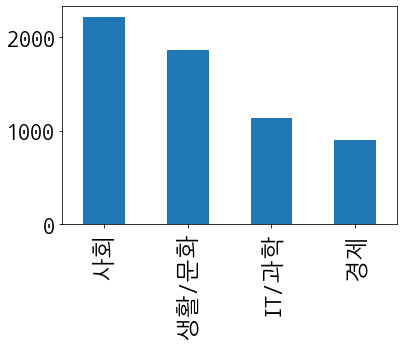

In [39]:
df3['code'].value_counts().plot(kind = 'bar')

In [40]:
print(df3.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학   1138
1     경제    901
2     사회   2222
3  생활/문화   1866


## Konlpy 사용

In [41]:
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [42]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_mecab(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = mecab.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_han(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = hannanum.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_kkma(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = kkma.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_komoran(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = komoran.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_okt(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = okt.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [43]:
text_data_han = preprocessing_han(df3['news'])
print(text_data_han[0])
print('han done')
text_data_mecab = preprocessing_mecab(df3['news'])
print(text_data_mecab[0])
print('mecab done')
text_data_kkma = preprocessing_kkma(df3['news'])
print(text_data_kkma[0])
print('kkma done')
text_data_komoran = preprocessing_komoran(df3['news'])
print(text_data_komoran[0])
print('komoran done')
text_data_okt = preprocessing_okt(df3['news'])
print(text_data_okt[0])
print('okt done')

파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기 자 파 아 주 시는 일 관내 취약계층 만가구 대 어 어 정부 긴급재난지원금 입금 완료했다파주시민 받 긴급재난지원금 일 ㄴ 이상 가구 기준 으로 만원 받 게 되 며 일 ㄴ 가구 만원 일 ㄴ 가구 만원 일 ㄴ 가구 만원이다정부 발표 ㄴ 긴급재난지원금 파주시민 지급 ㄴ 금액 다르 ㄴ 이유 국비지방비 부담 비율 때문이다파주시 이미 모든 시민 경기도파주시 재난기본소득인당 각 만원 지급 하고 어 시민 국비 지원금 만 지급 며 일 ㄴ 가구 기준 으로 총 지원 금액 파주시 재난기본소득 만원 경기 도 재난기본소득 만원 정부 긴급재난지원금 만원 총 만원 받 게 된다취약계층 아니 ㄴ 시민 오 월일 부터 소 지 하고 신용체크카드사 홈페이지 에서 긴급재난지원금 지원 신청 ㄹ 세대주 가족 지원금 일괄 신청 어야 한다한편 파 아 주 시는 일 김정기 부시장 단장 으로 긴급재난지원금 추진 태스크포스 를 구성해 긴급재난지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 저작권자 파이낸셜뉴스 전재재배포
han done
파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
X_train_han, X_test_han, y_train_han, y_test_han = train_test_split(text_data_han, df3['code'], random_state = 0)
X_train_mecab, X_test_mecab, y_train_mecab, y_test_mecab = train_test_split(text_data_mecab, df3['code'], random_state = 0)
X_train_kkma, X_test_kkma, y_train_kkma, y_test_kkma = train_test_split(text_data_kkma, df3['code'], random_state = 0)
X_train_komoran, X_test_komoran, y_train_komoran, y_test_komoran = train_test_split(text_data_komoran, df3['code'], random_state = 0)
X_train_okt, X_test_okt, y_train_okt, y_test_okt = train_test_split(text_data_okt, df3['code'], random_state = 0)
print('han 훈련용 뉴스 기사의 개수 :', len(X_train_han))
print('han 테스트용 뉴스 기사의 개수 : ', len(X_test_han))
print('han 훈련용 레이블의 개수 : ', len(y_train_han))
print('han 테스트용 레이블의 개수 : ', len(y_test_han))

print('mecab 훈련용 뉴스 기사의 개수 :', len(X_train_mecab))
print('mecab 테스트용 뉴스 기사의 개수 : ', len(X_test_mecab))
print('mecab 훈련용 레이블의 개수 : ', len(y_train_mecab))
print('mecab 테스트용 레이블의 개수 : ', len(y_test_mecab))

print('kkma 훈련용 뉴스 기사의 개수 :', len(X_train_kkma))
print('kkma 테스트용 뉴스 기사의 개수 : ', len(X_test_kkma))
print('kkma 훈련용 레이블의 개수 : ', len(y_train_kkma))
print('kkma 테스트용 레이블의 개수 : ', len(y_test_kkma))

print('komoran 훈련용 뉴스 기사의 개수 :', len(X_train_komoran))
print('komoran 테스트용 뉴스 기사의 개수 : ', len(X_test_komoran))
print('komoran 훈련용 레이블의 개수 : ', len(y_train_komoran))
print('komoran 테스트용 레이블의 개수 : ', len(y_test_komoran))

print('okt 훈련용 뉴스 기사의 개수 :', len(X_train_okt))
print('okt 테스트용 뉴스 기사의 개수 : ', len(X_test_okt))
print('okt 훈련용 레이블의 개수 : ', len(y_train_okt))
print('okt 테스트용 레이블의 개수 : ', len(y_test_okt))

han 훈련용 뉴스 기사의 개수 : 4595
han 테스트용 뉴스 기사의 개수 :  1532
han 훈련용 레이블의 개수 :  4595
han 테스트용 레이블의 개수 :  1532
mecab 훈련용 뉴스 기사의 개수 : 4595
mecab 테스트용 뉴스 기사의 개수 :  1532
mecab 훈련용 레이블의 개수 :  4595
mecab 테스트용 레이블의 개수 :  1532
kkma 훈련용 뉴스 기사의 개수 : 4595
kkma 테스트용 뉴스 기사의 개수 :  1532
kkma 훈련용 레이블의 개수 :  4595
kkma 테스트용 레이블의 개수 :  1532
komoran 훈련용 뉴스 기사의 개수 : 4595
komoran 테스트용 뉴스 기사의 개수 :  1532
komoran 훈련용 레이블의 개수 :  4595
komoran 테스트용 레이블의 개수 :  1532
okt 훈련용 뉴스 기사의 개수 : 4595
okt 테스트용 뉴스 기사의 개수 :  1532
okt 훈련용 레이블의 개수 :  4595
okt 테스트용 레이블의 개수 :  1532


In [85]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [86]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts_okt = count_vect.fit_transform(X_train_okt)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf_okt = tfidf_transformer.fit_transform(X_train_counts_okt)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf_okt = MultinomialNB().fit(X_train_tfidf_okt, y_train_okt)

In [72]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

## Report

In [87]:
y_pred_okt = clf_okt.predict(tfidf_vectorizer(X_test_okt))
print(metrics.classification_report(y_test_okt, y_pred_okt))

              precision    recall  f1-score   support

       IT/과학       0.86      0.69      0.77       288
          경제       0.91      0.40      0.55       236
          사회       0.71      0.92      0.80       553
       생활/문화       0.75      0.79      0.77       455

    accuracy                           0.76      1532
   macro avg       0.81      0.70      0.72      1532
weighted avg       0.78      0.76      0.75      1532



In [89]:
count_vect = CountVectorizer()
X_train_counts_han = count_vect.fit_transform(X_train_han)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_han = tfidf_transformer.fit_transform(X_train_counts_han)

clf_han = MultinomialNB().fit(X_train_tfidf_han, y_train_han)
y_pred_han = clf_han.predict(tfidf_vectorizer(X_test_han))
print(metrics.classification_report(y_test_han, y_pred_han))

              precision    recall  f1-score   support

       IT/과학       0.86      0.64      0.74       288
          경제       0.93      0.35      0.51       236
          사회       0.71      0.91      0.80       553
       생활/문화       0.71      0.81      0.75       455

    accuracy                           0.74      1532
   macro avg       0.80      0.68      0.70      1532
weighted avg       0.77      0.74      0.73      1532



In [90]:
count_vect = CountVectorizer()
X_train_counts_mecab = count_vect.fit_transform(X_train_mecab)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_mecab = tfidf_transformer.fit_transform(X_train_counts_mecab)

clf_mecab = MultinomialNB().fit(X_train_tfidf_mecab, y_train_mecab)
y_pred_mecab = clf_mecab.predict(tfidf_vectorizer(X_test_mecab))
print(metrics.classification_report(y_test_mecab, y_pred_mecab))

              precision    recall  f1-score   support

       IT/과학       0.86      0.71      0.78       288
          경제       0.90      0.40      0.56       236
          사회       0.72      0.92      0.81       553
       생활/문화       0.75      0.80      0.77       455

    accuracy                           0.76      1532
   macro avg       0.81      0.71      0.73      1532
weighted avg       0.78      0.76      0.75      1532



In [91]:
count_vect = CountVectorizer()
X_train_counts_kkma = count_vect.fit_transform(X_train_kkma)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_kkma = tfidf_transformer.fit_transform(X_train_counts_kkma)

clf_kkma = MultinomialNB().fit(X_train_tfidf_kkma, y_train_kkma)
y_pred_kkma = clf_kkma.predict(tfidf_vectorizer(X_test_kkma))
print(metrics.classification_report(y_test_kkma, y_pred_kkma))

              precision    recall  f1-score   support

       IT/과학       0.85      0.70      0.77       288
          경제       0.88      0.42      0.57       236
          사회       0.72      0.92      0.81       553
       생활/문화       0.75      0.79      0.77       455

    accuracy                           0.76      1532
   macro avg       0.80      0.71      0.73      1532
weighted avg       0.78      0.76      0.75      1532



In [92]:
count_vect = CountVectorizer()
X_train_counts_komoran = count_vect.fit_transform(X_train_komoran)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_komoran = tfidf_transformer.fit_transform(X_train_counts_komoran)

clf_komoran = MultinomialNB().fit(X_train_tfidf_komoran, y_train_komoran)
y_pred_komoran = clf_komoran.predict(tfidf_vectorizer(X_test_komoran))
print(metrics.classification_report(y_test_komoran, y_pred_komoran))

              precision    recall  f1-score   support

       IT/과학       0.86      0.72      0.78       288
          경제       0.91      0.42      0.57       236
          사회       0.73      0.92      0.81       553
       생활/문화       0.76      0.80      0.78       455

    accuracy                           0.77      1532
   macro avg       0.81      0.71      0.74      1532
weighted avg       0.79      0.77      0.76      1532

